# **Enfoque Estadístico del Aprendizaje**
# Ajuste del Modelo Lineal Simple y Múltiple por el Método del Gradiente Descendente (GD). Visualización del método iterativo.

Alumnas: Volpellier Daniela y Sandagorda Jessica

## Dataset: “Marketing Campaign Performance” <br>
(https://www.kaggle.com/datasets/manishabhatt22/marketing-campaign-performance-dataset)

In [24]:
install.packages("data.table")
library(data.table)

library(tidyverse)
library(readr)
library(ggplot2)

install.packages("plotly")
library(plotly)
library(htmlwidgets)

library(dplyr)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [25]:
download.file(
 "https://drive.google.com/uc?export=download&id=1j8LdmVKHfmSSuqpJ3iZipRT4_taaEEWt",
 destfile = "marketing_campaign_performance.csv",
 mode = "wb"
)

dataset <- fread("marketing_campaign_performance.csv")

class(dataset)


[1] "data.table" "data.frame"

El rendimiento de una campaña de marketing (ROI) se explica como una combinación lineal de sus métricas de desempeño —principalmente la tasa de conversión, el costo de adquisición, el engagement y el canal utilizado— y estos parámetros pueden ser estimados eficazmente mediante el método del Gradiente Descendente, visualizando el proceso iterativo de optimización.

### Hipótesis de Trabajo

El rendimiento de una campaña de marketing (ROI) puede analizarse mediante un modelo lineal simple y un modelo lineal múltiple ajustados con el método del Gradiente Descendente (GD). Se considera que las métricas de desempeño —tasa de conversión, costo de adquisición, engagement y canal utilizado— influyen de manera lineal sobre el ROI, y que los parámetros asociados pueden estimarse eficazmente mediante este método iterativo, visualizando su evolución a lo largo del proceso de optimización.

### Modelo Lineal Simple

Para ilustrar el Gradiente Descendente en su forma más básica, se propone un modelo lineal simple que utiliza:

- Variable respuesta: ROI de la campaña  
- Variable explicativa: Tasa de conversión (Conversion Rate)

#### Hipótesis

- **H₀:** La tasa de conversión no se relaciona linealmente con el ROI (β₁ = 0).  
- **H₁:** La tasa de conversión se relaciona positivamente con el ROI; a mayor conversión, mayor ROI (β₁ > 0).

Este modelo permite observar el comportamiento del Gradiente Descendente en dos dimensiones y visualizar cómo la función de costo disminuye en cada iteración.

### Modelo Lineal Múltiple

Se extiende el análisis incorporando múltiples predictores del dataset, tales como Acquisition Cost, Engagement Score y variables indicadoras del canal utilizado.

#### Hipótesis globales

- **H₀:** Ninguna de las métricas de desempeño se relaciona linealmente con el ROI (β₁ = β₂ = β₃ = … = 0).  
- **H₁:** Al menos una de las métricas del desempeño se relaciona linealmente con el ROI (∃ j : βⱼ ≠ 0).

Este modelo permite capturar de forma más completa la variabilidad del ROI y aplicar Gradiente Descendente en un espacio multidimensional, manteniendo la interpretación de la función de costo y su descenso iterativo.


## Limpieza inicial

In [26]:
# Duration_days a numérica

dataset <- dataset %>%
  mutate(Duration_days = as.numeric(gsub(" days", "", Duration)))

In [27]:
#Acquisition_Cost Viene como "$16,174.00". Hay que sacar símbolos y comas, y convertir a número
dataset <- dataset %>%
  mutate(Acquisition_Cost_num = parse_number(Acquisition_Cost))

In [28]:
# DateConvertir a tipo fecha

dataset <- dataset %>%
  mutate(Date = as.Date(Date))

## CREACIÓN DE LA VARIABLE OBJETIVO

construir ROI_synth en escala estandarizada

Estandarizar las variables numéricas (z-score).

Combinar esas z con pesos que reflejen “importancia”.

Mover todo a una escala parecida a la del ROI original (tipo centro en 5, rango 2–8).

Como el dataset original tiene variables en escalas muy distintas, primero las estandarizamos y construimos un ROI sintético como combinación lineal de Conversion_Rate, impresiones, costo, engagement y duración.
De esa forma controlamos qué variable tiene más peso y después usamos ese ROI para ilustrar regresión lineal simple y múltiple con descenso por el gradiente.

In [29]:
#  Estandarizo las variables que quiero usar
dataset <- dataset %>%
  mutate(
    conv_z = as.numeric(scale(Conversion_Rate)),
    impr_z = as.numeric(scale(Impressions)),
    acq_z  = as.numeric(scale(Acquisition_Cost_num)),
    eng_z  = as.numeric(scale(Engagement_Score)),
    dur_z  = as.numeric(scale(Duration_days))
  )

In [30]:
# Defino un ROI sintético
#    - Conversion_Rate: peso más grande (protagonista para la simple)
#    - Engagement, Impressions, Duration: aportan pero menos
#    - Acquisition_Cost: efecto negativo fuerte (campañas caras rinden menos)

set.seed(230101)

dataset <- dataset %>%
  mutate(
    ROI_synth = 5 +                      # centro alrededor de 5
      0.8 * conv_z +                     # peso FUERTE → simple con buena pendiente
      0.4 * eng_z  +                     # engagement ayuda
      0.3 * impr_z -                     # más impresiones, más ROI
      0.5 * acq_z  +                     # más costo → baja el ROI
      0.2 * dur_z  +                     # campañas más largas suman un poco
      rnorm(n(), mean = 0, sd = 0.5)     # ruido moderado
  )

### correlación

In [31]:
dataset %>%
  select(ROI_synth, Conversion_Rate, Impressions,
         Acquisition_Cost_num, Engagement_Score, Duration_days) %>%
  cor(use = "complete.obs")

,ROI_synth,Conversion_Rate,Impressions,Acquisition_Cost_num,Engagement_Score,Duration_days
ROI_synth,1.0000000,0.6673888446,0.251294473,-0.4189716299,0.3359925032,0.1641598904
Conversion_Rate,0.6673888,1.0000000000,-0.002833546,0.0007178727,-0.0006383944,-0.0010576679
Impressions,0.2512945,-0.0028335463,1.000000000,0.0003286440,0.0030297139,-0.0063231933
Acquisition_Cost_num,-0.4189716,0.0007178727,0.000328644,1.0000000000,-0.0032176160,0.0009414317
Engagement_Score,0.3359925,-0.0006383944,0.003029714,-0.0032176160,1.0000000000,-0.0030093179
Duration_days,0.1641599,-0.0010576679,-0.006323193,0.0009414317,-0.0030093179,1.0000000000


## Modelo Lineal Simple

### modelo analítico

In [32]:

# modelo lineal simple "de referencia" (solución analítica)
modelo_lm_simple <- lm(ROI_synth ~ Conversion_Rate, data = dataset)
summary(modelo_lm_simple)





Call:
lm(formula = ROI_synth ~ Conversion_Rate, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6152 -0.6161  0.0028  0.6156  3.6338 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.425612   0.004403   778.0   <2e-16 ***
Conversion_Rate 19.656464   0.049046   400.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8905 on 199998 degrees of freedom
Multiple R-squared:  0.4454,	Adjusted R-squared:  0.4454 
F-statistic: 1.606e+05 on 1 and 199998 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


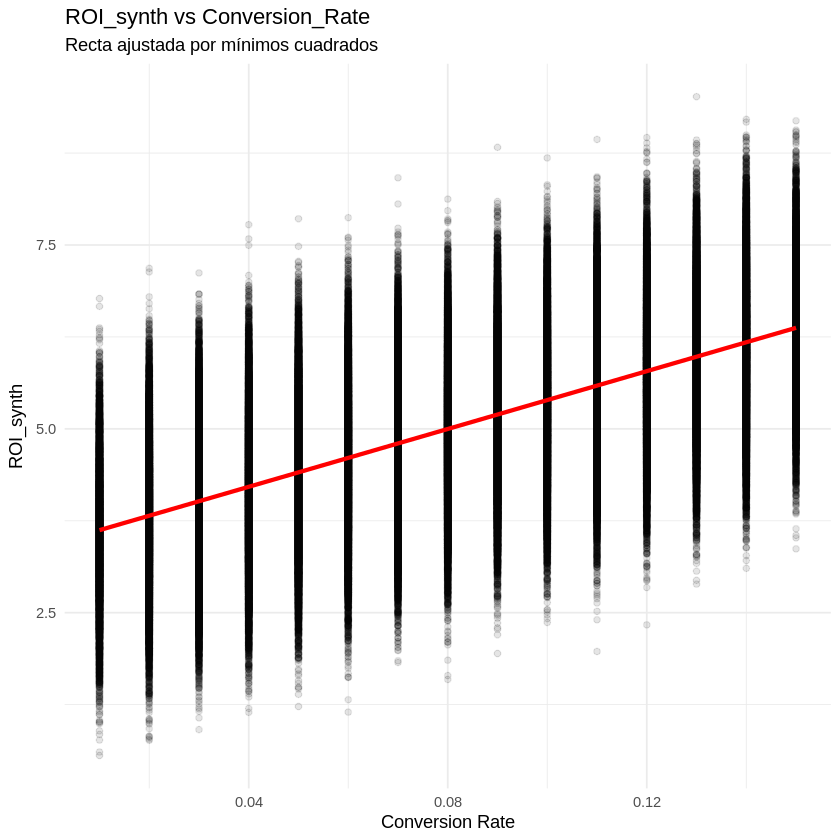

In [33]:
# gráfico: nube + recta de lm
ggplot(dataset, aes(x = Conversion_Rate, y = ROI_synth)) +
  geom_point(alpha = 0.1) +
  geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 1.2) +
  labs(
    title = "ROI_synth vs Conversion_Rate",
    subtitle = "Recta ajustada por mínimos cuadrados",
    x = "Conversion Rate",
    y = "ROI_synth"
  ) +
  theme_minimal()

### descenso por el gradiente en el modelo lineal simple

1. Preparar datos

In [34]:
# 1) Datos del modelo simple
datos_simple <- dataset %>%
  select(ROI_synth, Conversion_Rate, conv_z) %>%
  drop_na()


In [35]:
# Matriz de diseño EXACTAMENTE como la usa lm()
X <- model.matrix(ROI_synth ~ conv_z, data = datos_simple)
y <- datos_simple$ROI_synth

n <- nrow(X)
p <- ncol(X)

2. Descenso por el gradiente

In [36]:
# 2) Descenso por el gradiente
alpha  <- 0.01      # tasa de aprendizaje
n_iter <- 1000L     # más iteraciones para asegurar convergencia

beta  <- rep(0, p)  # (beta0, beta1)
costo <- numeric(n_iter)

for (t in 1:n_iter) {
  y_hat <- as.numeric(X %*% beta)
  error <- y_hat - y
  grad  <- (1 / n) * t(X) %*% error
  beta  <- beta - alpha * as.numeric(grad)
  costo[t] <- mean(error^2) / 2
}

beta

[1] 4.9992826 0.7980504

3. Gráfico de la función de costo vs iteraciones

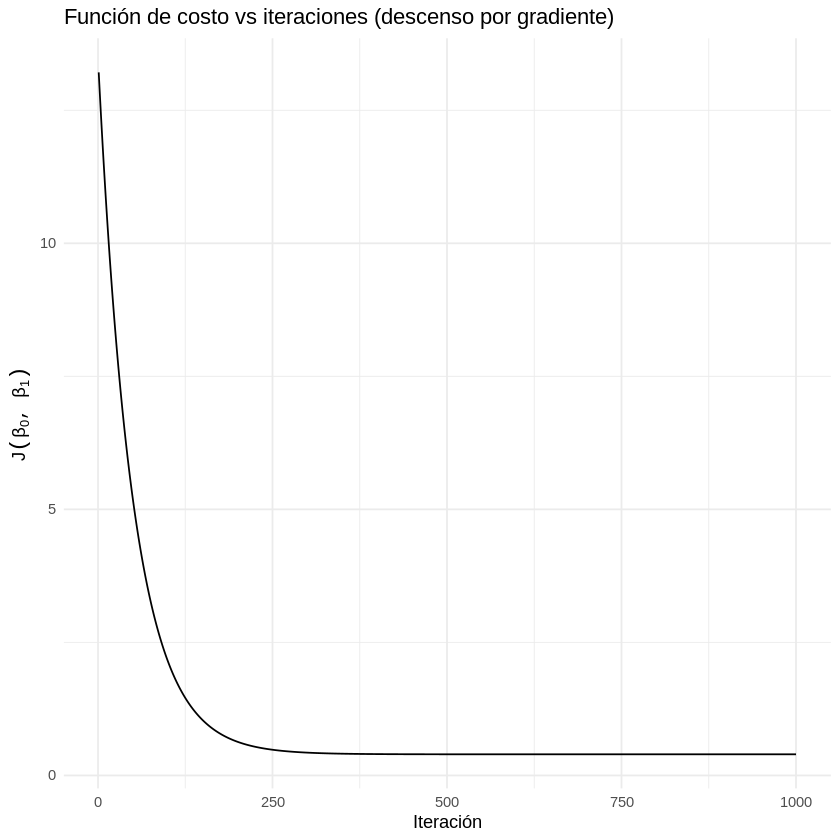

In [37]:
df_costo <- tibble(
  iter  = 1:n_iter,
  costo = costo
)

ggplot(df_costo, aes(x = iter, y = costo)) +
  geom_line() +
  labs(
    title = "Función de costo vs iteraciones (descenso por gradiente)",
    x = "Iteración",
    y = expression(J(beta[0], beta[1]))
  ) +
  theme_minimal()


### Animación GD y Learning rate

In [38]:
# ==============================================================================
# VISUALIZACIÓN INTERACTIVA EN UNIDADES REALES
# ==============================================================================

old_warn <- getOption("warn")
options(warn = -1)

# 1. Asegurar Datos
if(!exists("dataset")) stop("Cargá el dataset primero")

# Media y desvío de la variable REAL (Conversion_Rate)
mu    <- mean(dataset$Conversion_Rate, na.rm = TRUE)
sigma <- sd(dataset$Conversion_Rate,   na.rm = TRUE)

# Muestra para velocidad (SIEMPRE LA MISMA PARA COMPARAR ALPHAS)
set.seed(123)
datos_plot <- dataset %>%
  select(ROI_synth, Conversion_Rate, conv_z) %>%
  drop_na() %>%
  sample_n(min(nrow(.), 500))

# Entrenamos SIEMPRE en conv_z (mundo estandarizado)
X_vec <- datos_plot$conv_z
y_vec <- datos_plot$ROI_synth
m     <- length(y_vec)

# Óptimo analítico en conv_z (para centrar el bowl, es el mismo para todos los alpha)
mod_opt <- lm(ROI_synth ~ conv_z, data = datos_plot)
b0_opt  <- coef(mod_opt)[1]
b1_opt  <- coef(mod_opt)[2]

half_width_b0 <- 5
half_width_b1 <- 5

b0_grid <- seq(b0_opt - half_width_b0, b0_opt + half_width_b0, length.out = 80)
b1_grid <- seq(b1_opt - half_width_b1, b1_opt + half_width_b1, length.out = 80)

Z_bowl <- outer(
  b0_grid, b1_grid,
  Vectorize(function(b0, b1) {
    mean((y_vec - (b0 + b1 * X_vec))^2) / 2
  })
)

range_b0 <- range(b0_grid)
range_b1 <- range(b1_grid)




In [39]:
# =========================
# FUNCIÓN PARA GENERAR EL HTML DADO alpha
# =========================

generar_html_gradiente <- function(alpha, n_iter = 70, file_name = "gradiente.html") {
  cat("\n===============================\n")
  cat("Corriendo GD con alpha =", alpha, " - n_iter =", n_iter, "\n")
  cat("Guardando en:", file_name, "\n")
  cat("===============================\n\n")

  # 2. Gradiente en Z para guardar la historia de betas
  beta   <- c(0, 0)
  historia <- data.frame(iter = integer(), b0 = numeric(), b1 = numeric(), costo = numeric())
  X_mat    <- cbind(1, X_vec)

  for(i in 1:n_iter) {
    y_hat     <- X_mat %*% beta
    error     <- y_hat - y_vec
    costo_val <- sum(error^2) / (2 * m)

    historia <- rbind(
      historia,
      data.frame(iter = i, b0 = beta[1], b1 = beta[2], costo = costo_val)
    )

    grad <- (t(X_mat) %*% error) / m
    beta <- beta - alpha * as.vector(grad)
  }

  # 3. TRADUCIR BETAS A MUNDO REAL
  historia_real <- historia %>%
    mutate(
      pend_real  = b1 / sigma,
      inter_real = b0 - (b1 * mu / sigma)
    )

  # Rango REAL para dibujar la recta
  x_min_real <- min(datos_plot$Conversion_Rate)
  x_max_real <- max(datos_plot$Conversion_Rate)

  lineas_df_real <- historia_real %>%
    rowwise() %>%
    do({
      data.frame(
        iter = .$iter,
        x    = c(x_min_real, x_max_real),
        y    = c(.$inter_real + .$pend_real * x_min_real,
                 .$inter_real + .$pend_real * x_max_real)
      )
    }) %>%
    ungroup()

  # 5. CONSTRUIR GRÁFICOS

  # IZQUIERDA: datos en eje REAL + recta des-escalada
  p_left <- plot_ly() %>%
    add_markers(
      data   = datos_plot,
      x      = ~Conversion_Rate,
      y      = ~ROI_synth,
      marker = list(color = "rgba(0,0,0,0.3)", size = 5),
      name   = "Datos Reales",
      hoverinfo = "none"
    ) %>%
    add_lines(
      data   = lineas_df_real,
      x      = ~x,
      y      = ~y,
      frame  = ~iter,
      group  = ~iter,
      line   = list(color = "red", width = 3),
      name   = "Modelo"
    )

  # DERECHA: bowl de costo centrado en (b0_opt, b1_opt)
  p_right <- plot_ly() %>%
    add_contour(
      x = b0_grid, y = b1_grid, z = t(Z_bowl),
      colorscale = "Viridis",
      ncontours  = 30,
      name       = "Función de Costo"
    ) %>%
    add_markers(
      data  = historia,
      x     = ~b0,
      y     = ~b1,
      frame = ~iter,
      text  = ~paste0(
        "Iteración: ", iter,
        "<br>β0 = ", round(b0, 4),
        "<br>β1 = ", round(b1, 4)
      ),
      hoverinfo = "text",
      marker = list(color = "red", size = 10, line = list(color = "white", width = 2)),
      name   = "Betas Actuales"
    )

  # 6. UNIR Y MOSTRAR
  fig <- subplot(p_left, p_right, titleX = TRUE, margin = 0.05) %>%
    layout(
      title      = paste0("Descenso del Gradiente (α = ", alpha, ") - eje X en unidades reales"),
      showlegend = FALSE,

      # Ejes del gráfico de la izquierda (zoom fijo)
      xaxis = list(
        title     = "Tasa de Conversión (Real)",
        range     = c(0, 0.2),
        autorange = FALSE
      ),
      yaxis = list(
        title = "ROI"
      ),

      # Ejes del gráfico de la derecha (bowl centrado)
      xaxis2 = list(
        title     = "Beta 0",
        range     = range_b0,
        autorange = FALSE
      ),
      yaxis2 = list(
        title       = "Beta 1",
        range       = range_b1,
        autorange   = FALSE,
        scaleanchor = "x2",
        scaleratio  = 1
      )
    ) %>%
    animation_opts(frame = 0, transition = 0, redraw = TRUE) %>%
    animation_slider(
      currentvalue = list(prefix = "Iteración: ", font = list(color = "red"))
    )

  saveWidget(fig, file_name, selfcontained = TRUE)

  # EXTRA: imprimir últimos betas
  beta_final <- tail(historia_real, 1)
  cat(sprintf(
    "α = %.4f | Betas Z finales: b0 = %.4f, b1 = %.4f\n",
    alpha, beta_final$b0, beta_final$b1
  ))
  cat(sprintf(
    "α = %.4f | Betas REAL finales: inter_real = %.4f, pend_real = %.4f\n\n",
    alpha, beta_final$inter_real, beta_final$pend_real
  ))
}

In [40]:
# =========================
# LLAMADAS CON 3 LEARNING RATES DISTINTOS
# =========================

generar_html_gradiente(alpha = 0.1, n_iter = 70,
                       file_name = "Gradiente_Interactivo_Real_LR01.html")

generar_html_gradiente(alpha = 0.01,  n_iter = 70,
                       file_name = "Gradiente_Interactivo_Real_LR001.html")

generar_html_gradiente(alpha = 1.5,  n_iter = 70,
                       file_name = "Gradiente_Interactivo_Real_LR15.html")

options(warn = old_warn)


Corriendo GD con alpha = 0.1  - n_iter = 70 
Guardando en: Gradiente_Interactivo_Real_LR01.html 

α = 0.1000 | Betas Z finales: b0 = 4.9648, b1 = 0.7973
α = 0.1000 | Betas REAL finales: inter_real = 3.3925, pend_real = 19.6365


Corriendo GD con alpha = 0.01  - n_iter = 70 
Guardando en: Gradiente_Interactivo_Real_LR001.html 

α = 0.0100 | Betas Z finales: b0 = 2.4642, b1 = 0.2738
α = 0.0100 | Betas REAL finales: inter_real = 1.9242, pend_real = 6.7441


Corriendo GD con alpha = 1.5  - n_iter = 70 
Guardando en: Gradiente_Interactivo_Real_LR15.html 

α = 1.5000 | Betas Z finales: b0 = 4.9691, b1 = 0.8002
α = 1.5000 | Betas REAL finales: inter_real = 3.3910, pend_real = 19.7087



### ¿Llegan al mismo lugar? Mínimos cuadrados vs gradiente

In [41]:

modelo_lm_simple <- lm(ROI_synth ~ conv_z, data = datos_simple)
coef_lm <- coef(modelo_lm_simple)

tabla_coef <- tibble::tibble(
  parametro  = c("β0 (Intercepto)", "β1 (coef. conv_z)"),
  coef_lm    = as.numeric(coef_lm),
  coef_GD    = as.numeric(beta),
  diferencia = coef_GD - coef_lm
)
tabla_coef

parametro,coef_lm,coef_GD,diferencia
<chr>,<dbl>,<dbl>,<dbl>
β0 (Intercepto),4.9994984,4.9992826,-2.158346e-04
β1 (coef. conv_z),0.7980848,0.7980504,-3.445606e-05


### Recta por mínimos cuadrados vs recta por gradiente

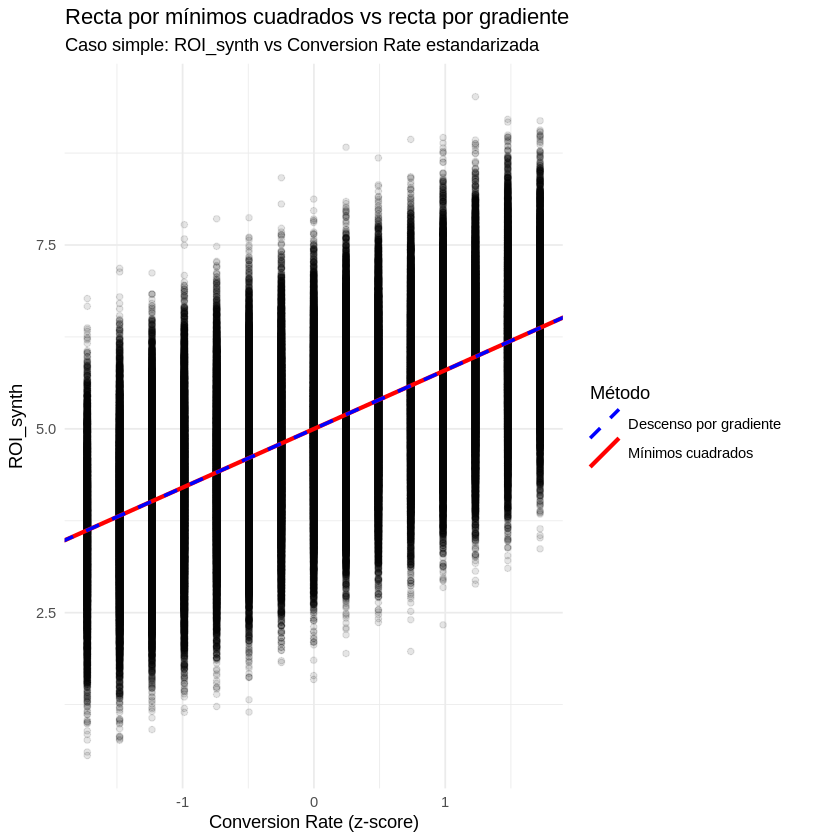

In [42]:
ggplot(datos_simple, aes(x = conv_z, y = ROI_synth)) +
  geom_point(alpha = 0.1) +
  geom_abline(
    aes(
      slope     = coef_lm[2],
      intercept = coef_lm[1],
      color     = "Mínimos cuadrados"
    ),
    linewidth = 1.2
  ) +
  geom_abline(
    aes(
      slope     = beta[2],
      intercept = beta[1],
      color     = "Descenso por gradiente"
    ),
    linetype  = "dashed",
    linewidth = 1
  ) +
  scale_color_manual(
    name   = "Método",
    values = c(
      "Mínimos cuadrados"      = "red",
      "Descenso por gradiente" = "blue"
    )
  ) +
  labs(
    title    = "Recta por mínimos cuadrados vs recta por gradiente",
    subtitle = "Caso simple: ROI_synth vs Conversion Rate estandarizada",
    x = "Conversion Rate (z-score)",
    y = "ROI_synth"
  ) +
  theme_minimal()


## Modelo Lineal multiple

In [43]:
modelo_lm_mult <- lm(
  ROI_synth ~ conv_z + acq_z + eng_z + impr_z + dur_z,
  data = dataset
)

summary(modelo_lm_mult)


Call:
lm(formula = ROI_synth ~ conv_z + acq_z + eng_z + impr_z + dur_z, 
    data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14791 -0.33699  0.00009  0.33811  2.32816 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.999498   0.001117  4475.3   <2e-16 ***
conv_z       0.799771   0.001117   715.9   <2e-16 ***
acq_z       -0.500594   0.001117  -448.1   <2e-16 ***
eng_z        0.400377   0.001117   358.4   <2e-16 ***
impr_z       0.302993   0.001117   271.2   <2e-16 ***
dur_z        0.200746   0.001117   179.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4996 on 199994 degrees of freedom
Multiple R-squared:  0.8255,	Adjusted R-squared:  0.8255 
F-statistic: 1.892e+05 on 5 and 199994 DF,  p-value: < 2.2e-16


In [44]:
# ==============================================================================
# GRÁFICOS 3D CORREGIDOS: VISUALIZACIÓN COMPLETA
# ==============================================================================

# 1. DATOS REALES
if(!exists("dataset")) stop("¡Cargá el dataset primero!")
datos_real_full <- dataset %>%
  select(ROI_synth, Acquisition_Cost_num, Conversion_Rate) %>%
  drop_na()


# ==============================================================================
#  LA SOLUCIÓN (ESCALADOS) - AHORA SÍ EL BOWL COMPLETO
# ==============================================================================
Costo_Z <- as.numeric(scale(datos_real_full$Acquisition_Cost_num))
Tasa_Z  <- as.numeric(scale(datos_real_full$Conversion_Rate))


grid_z <- seq(-10, 10, length.out = 40)

z_scaled <- outer(grid_z, grid_z, Vectorize(function(b1, b2) {
  y_hat <- b1 * Costo_Z + b2 * Tasa_Z
  mean((datos_real_full$ROI_synth - y_hat)^2) / 2
}))

fig_scaled <- plot_ly(x = ~grid_z, y = ~grid_z, z = ~z_scaled) %>%
  add_surface(
    contours = list(z = list(show=TRUE, usecolormap=TRUE, highlightcolor="#ff0000", project=list(z=TRUE))),
    colorscale = "Viridis"
  ) %>%
  layout(
    title = "B) Datos Escalados: El Bowl Simétrico",
    scene = list(
      xaxis = list(title = "Beta Costo (Z)"),
      yaxis = list(title = "Beta Tasa (Z)"),
      zaxis = list(title = "Error"),
      aspectratio = list(x=1, y=1, z=0.7)
    )
  )

# GUARDAR
saveWidget(fig_scaled, "3D_Bueno_Corregido.html", selfcontained = TRUE)
print("Se generó el archivo '3D_Bueno_Corregido.html'")

[1] "Se generó el archivo '3D_Bueno_Corregido.html'"


In [45]:
# ==============================================================================
# Datos Crudos: Vista Panorámica
# ==============================================================================

# 1. PREPARAR DATOS
if(!exists("dataset")) stop("¡Cargá el dataset primero!")

datos_real_full <- dataset %>%
  select(ROI_synth, Acquisition_Cost_num, Conversion_Rate) %>%
  drop_na()

print("Generando vista panorámica del gráfico crudo...")

# 2. DEFINIR RANGOS "PANORÁMICOS"
# El truco acá es encontrar dónde "dobla" la curva sin irnos al infinito.

# Rango para Beta Costo: Es súper sensible. Nos movemos muy poquito alrededor del 0.
# (Cualquier valor mayor a 0.002 ya genera errores monstruosos)
b_costo_seq <- seq(-0.002, 0.002, length.out = 50)

# Rango para Beta Tasa: Es poco sensible. Necesitamos un rango GIGANTE para ver la curva.
# Vamos de -100 a +150 para intentar capturar la subida de las paredes.
b_tasa_seq  <- seq(-100, 150, length.out = 50)

# 3. CALCULAR MATRIZ Z (ERROR)
z_raw_full <- outer(b_costo_seq, b_tasa_seq, Vectorize(function(b1, b2) {
  y_hat <- b1 * datos_real_full$Acquisition_Cost_num + b2 * datos_real_full$Conversion_Rate
  mean((datos_real_full$ROI_synth - y_hat)^2) / 2
}))

# 4. GRAFICAR CON ZOOM ALEJADO
fig_raw_full <- plot_ly(x = ~b_costo_seq, y = ~b_tasa_seq, z = ~z_raw_full) %>%
  add_surface(
    contours = list(
      z = list(
        show = TRUE,
        usecolormap = TRUE,
        highlightcolor = "#ff0000",
        project = list(z = TRUE)
      )
    ),
    colorscale = "Earth" # Usamos colores de tierra para diferenciarlo del "bueno"
  ) %>%
  layout(
    title = "Datos Crudos: Vista Panorámica (El Valle Angosto)",
    scene = list(
      xaxis = list(title = "Beta Costo (Miles $)"),
      yaxis = list(title = "Beta Tasa (%)"),
      zaxis = list(title = "Error (MSE)"),
      aspectratio = list(x=1, y=4, z=1.5)
    )
  )

# 5. GUARDAR
saveWidget(fig_raw_full, "3D_Completo_Crudo.html", selfcontained = TRUE)
print("¡Listo! Abrí el archivo '3D_Completo_Crudo.html'.")

[1] "Generando vista panorámica del gráfico crudo..."
[1] "¡Listo! Abrí el archivo '3D_Completo_Crudo.html'."


### Comparación RLM: lm() vs GD

In [46]:
# 1) Dataset para el modelo múltiple (variables YA escaladas)
datos_rlm <- dataset %>%
  select(ROI_synth, conv_z, acq_z, eng_z, impr_z, dur_z) %>%
  drop_na()

# Matriz de diseño y vector respuesta
X <- model.matrix(ROI_synth ~ conv_z + acq_z + eng_z + impr_z + dur_z,
                  data = datos_rlm)
y <- datos_rlm$ROI_synth

n <- nrow(X)
p <- ncol(X)

# 2) Modelo analítico con lm()
mod_lm   <- lm(ROI_synth ~ conv_z + acq_z + eng_z + impr_z + dur_z,
               data = datos_rlm)
coef_lm  <- coef(mod_lm)

# 3) Gradiente Descendente vectorizado
alpha  <- 0.01      # tasa de aprendizaje razonable para datos escalados
n_iter <- 1000L

beta  <- rep(0, p)  # (β0, β_conv, β_acq, β_eng, β_impr, β_dur)
costo <- numeric(n_iter)

for(t in 1:n_iter){
  y_hat <- as.numeric(X %*% beta)
  error <- y_hat - y
  grad  <- (1 / n) * t(X) %*% error
  beta  <- beta - alpha * as.numeric(grad)
  costo[t] <- mean(error^2) / 2
}



# 4) Tabla de comparación de coeficientes

tabla_comp <- tibble(
  parametro  = names(coef_lm),
  coef_lm    = as.numeric(coef_lm),
  coef_GD    = as.numeric(beta),
  diferencia = as.numeric(beta - coef_lm)
)

tabla_comp_precisa <- tabla_comp %>%
  mutate(
    coef_lm    = sprintf("%.10f", coef_lm),
    coef_GD    = sprintf("%.10f", coef_GD),
    diferencia = sprintf("%.10f", diferencia)
  )


print(tabla_comp_precisa)
cat("\nMáxima diferencia absoluta entre lm() y GD:\n")
max_abs_diff <- max(abs(tabla_comp$diferencia))
print(max_abs_diff)


# A tibble: 6 × 4
  parametro   coef_lm       coef_GD       diferencia   
  <chr>       <chr>         <chr>         <chr>        
1 (Intercept) 4.9994984475  4.9992826129  -0.0002158346
2 conv_z      0.7997706678  0.7997353796  -0.0000352882
3 acq_z       -0.5005940620 -0.5005726115 0.0000214505 
4 eng_z       0.4003765132  0.4003598268  -0.0000166864
5 impr_z      0.3029929670  0.3029787191  -0.0000142479
6 dur_z       0.2007455365  0.2007349040  -0.0000106326

Máxima diferencia absoluta entre lm() y GD:
[1] 0.0002158346



### Evolución de los coeficientes en la RLM (Gradiente Descendente)

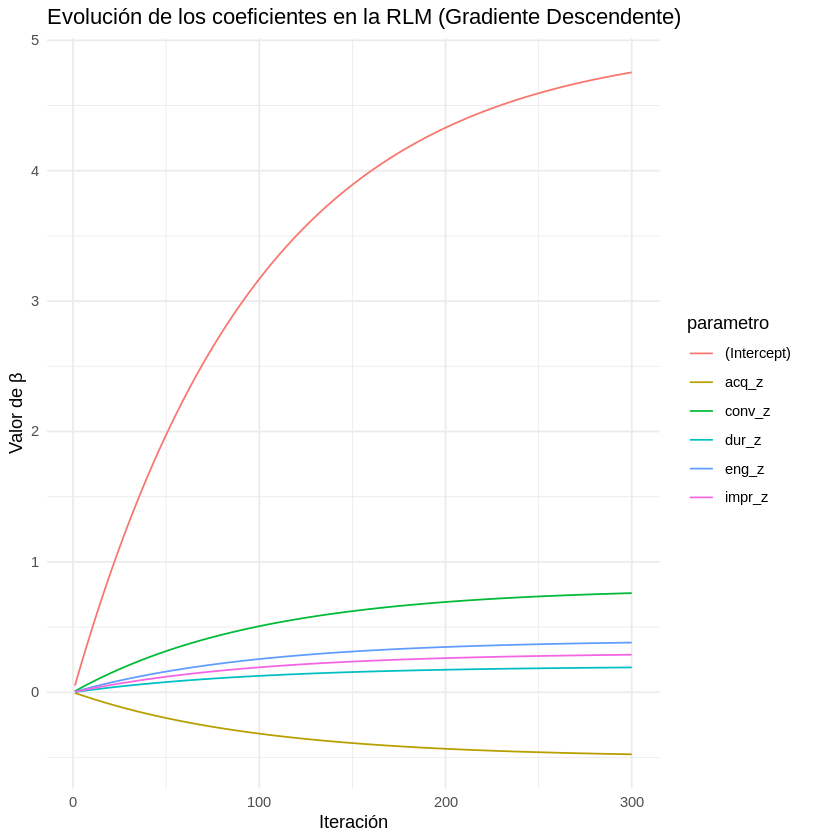

In [47]:

# Matriz de diseño para RLM con las z
datos_rlm <- dataset %>%
  select(ROI_synth, conv_z, acq_z, eng_z, impr_z, dur_z) %>%
  drop_na()

X <- model.matrix(ROI_synth ~ conv_z + acq_z + eng_z + impr_z + dur_z,
                  data = datos_rlm)
y <- datos_rlm$ROI_synth

n      <- nrow(X)
p      <- ncol(X)
alpha  <- 0.01
n_iter <- 300

beta_hist <- matrix(NA_real_, nrow = n_iter, ncol = p)
costo_rlm <- numeric(n_iter)

beta <- rep(0, p)

for(i in 1:n_iter){
  y_hat <- as.numeric(X %*% beta)
  error <- y_hat - y

  grad  <- (1/n) * t(X) %*% error
  beta  <- beta - alpha * as.numeric(grad)

  beta_hist[i, ] <- beta
  costo_rlm[i]   <- mean(error^2) / 2
}

colnames(beta_hist) <- colnames(X)

hist_rlm <- as.data.frame(beta_hist) %>%
  mutate(iter = 1:n_iter) %>%
  pivot_longer(
    cols = -iter,
    names_to = "parametro",
    values_to = "valor"
  )

ggplot(hist_rlm, aes(x = iter, y = valor, color = parametro)) +
  geom_line() +
  labs(
    title = "Evolución de los coeficientes en la RLM (Gradiente Descendente)",
    x = "Iteración",
    y = "Valor de β"
  ) +
  theme_minimal()


### RLM: Función de costo vs iteraciones (GD)

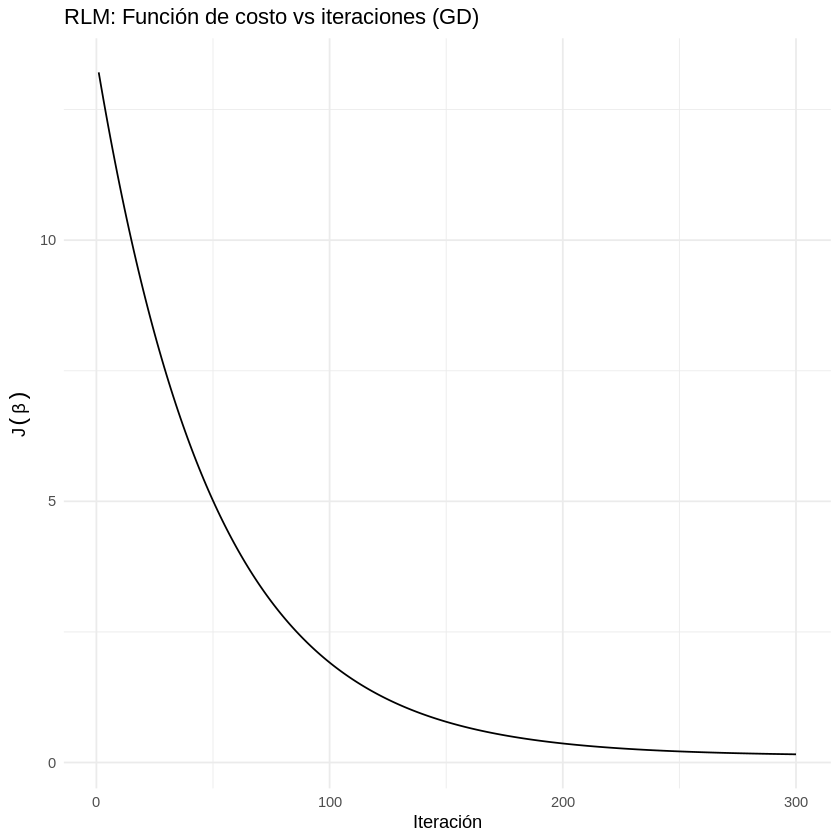

In [48]:
df_costo_rlm <- tibble(
  iter  = 1:n_iter,
  costo = costo_rlm
)

ggplot(df_costo_rlm, aes(x = iter, y = costo)) +
  geom_line() +
  labs(
    title = "RLM: Función de costo vs iteraciones (GD)",
    x = "Iteración",
    y = expression(J(beta))
  ) +
  theme_minimal()
